In [ ]:
import math
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor

import matplotlib.pyplot as plt
import seaborn as sbn

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using '{device}'!")

Using 'cuda:0'!


In [ ]:
def t2d(tensor, device):
    """Move tensors to a specified device.
    Args:
        tensor (Union[torch.Tensor, Mapping[str, torch.Tensor], Sequence[torch.Tensor]]):
            data to move to a device.
        device (Union[str, torch.device]): device where should be moved device
    Returns:
        Union[torch.Tensor, Mapping[str, torch.Tensor], Sequence[torch.Tensor]]:
            data moved to a specified device
    """
    if isinstance(tensor, torch.Tensor):
        return tensor.to(device)
    elif isinstance(tensor, (tuple, list)):
        # recursive move to device
        return [t2d(_tensor, device) for _tensor in tensor]
    elif isinstance(tensor, dict):
        res = {}
        for _key, _tensor in tensor.items():
            res[_key] = t2d(_tensor, device)
        return res


def seed_all(seed: int = 42):
    """Fix all seeds.

    Args:
        seed (int): seed number
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
def get_transforms(dataset: str):
    """Get transforms depends from dataset.
    Args:
        dataset (str): dataset type (train or valid)
    Returns:
        dataset transforms
    """
    return Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])


def get_loaders(stage: str) -> tuple:
    """Loaders for a stage.
    Args:
        stage (str): stage name
    Returns:
        training and validation loader
    """
    trainset = MNIST(
        "./data", train=False, download=True, transform=get_transforms("train"),
    )
    testset = MNIST(
        "./data", train=False, download=True, transform=get_transforms("valid"),
    )
    train = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)
    valid = DataLoader(testset, batch_size=64, shuffle=True, num_workers=1)
    return train, valid

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, n_classes: int = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, n_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# source: https://github.com/ZhaoJ9014/face.evoLVe.PyTorch/blob/d5e31893f7e30c0f82262e701463fd83d9725381/head/metrics.py

class CosFace(nn.Module):
    r"""Implement of CosFace (https://arxiv.org/pdf/1801.09414.pdf):

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        device_id: the ID of GPU where the model will be trained by model parallel.
            if device_id=None, it will be trained on CPU without model parallel.
        s: norm of input feature
        m: margin
        cos(theta)-m
    """

    def __init__(self, in_features, out_features, device_id, s=64.0, m=0.35):
        super(CosFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.device_id = device_id
        self.s = s
        self.m = m

        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        if self.device_id is None:
            cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        else:
            x = input
            sub_weights = torch.chunk(self.weight, len(self.device_id), dim=0)
            temp_x = x.cuda(self.device_id[0])
            weight = sub_weights[0].cuda(self.device_id[0])
            cosine = F.linear(F.normalize(temp_x), F.normalize(weight))
            for i in range(1, len(self.device_id)):
                temp_x = x.cuda(self.device_id[i])
                weight = sub_weights[i].cuda(self.device_id[i])
                cosine = torch.cat(
                    (
                        cosine,
                        F.linear(F.normalize(temp_x), F.normalize(weight)).cuda(
                            self.device_id[0]
                        ),
                    ),
                    dim=1,
                )
        phi = cosine - self.m
        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cosine.size()).to(input.device)
        if self.device_id is not None:
            one_hot = one_hot.cuda(self.device_id[0])
        # one_hot = one_hot.cuda() if cosine.is_cuda else one_hot
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + (
            (1.0 - one_hot) * cosine
        )  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s

        return output

In [ ]:
class EncoderWithHead(nn.Module):
    def __init__(self, encoder: nn.Module, head: nn.Module):
        super().__init__()
        self.encoder = encoder
        self.head = head

    def forward(
        self, images: torch.tensor, targets: torch.tensor = None
    ) -> torch.tensor:
        features = self.encoder(images)
        if targets is None:
            return features
        outputs = self.head(features, targets)
        return outputs

In [ ]:
seed_all(2020)

model = EncoderWithHead(
    encoder=SimpleNet(n_classes=2),
    head=CosFace(2, 10, None),
)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-5)
# optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model

EncoderWithHead(
  (encoder): SimpleNet(
    (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=800, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=2, bias=True)
  )
  (head): CosFace()
)

In [ ]:
train_loader, valid_loader = get_loaders("")
n_epochs = 100
for epoch in range(1, n_epochs + 1):
    model.train()
    train_loss = []
    for batch in train_loader:
        x, y = t2d(batch, device)
        output = model(x, y)
        loss = criterion(output, y)
        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = np.mean(train_loss)
    model.eval()
    valid_loss = []
    accuracy = []
    with torch.no_grad():
        for batch in valid_loader:
            x, y = t2d(batch, device)
            output = model(x, y)
            loss = criterion(output, y)
            torch.argmax(output)
            valid_loss.append(loss.item())
            acc = (torch.argmax(output, -1) == y).sum().detach().item()
            acc /= y.size(0)
            accuracy.append(acc)
    valid_loss = np.mean(valid_loss)
    accuracy = np.mean(accuracy)
    print(f"Epoch {epoch}/{n_epochs}: train - {train_loss:.5f}, valid - {valid_loss:.5f} (accuracy - {accuracy:.5f})")

Epoch 1/100: train - 27.16172, valid - 22.44303 (accuracy - 0.04070)
Epoch 2/100: train - 20.82063, valid - 20.43499 (accuracy - 0.15018)
Epoch 3/100: train - 19.84465, valid - 19.56613 (accuracy - 0.17207)
Epoch 4/100: train - 18.83647, valid - 17.70434 (accuracy - 0.27229)
Epoch 5/100: train - 16.78876, valid - 15.22369 (accuracy - 0.33957)
Epoch 6/100: train - 15.72196, valid - 14.79430 (accuracy - 0.37799)
Epoch 7/100: train - 15.18563, valid - 14.84927 (accuracy - 0.38256)
Epoch 8/100: train - 13.93528, valid - 12.94214 (accuracy - 0.43093)
Epoch 9/100: train - 13.69110, valid - 13.11814 (accuracy - 0.38037)
Epoch 10/100: train - 12.16520, valid - 11.13791 (accuracy - 0.39222)
Epoch 11/100: train - 11.57637, valid - 13.60361 (accuracy - 0.13455)
Epoch 12/100: train - 13.94544, valid - 12.19414 (accuracy - 0.31648)
Epoch 13/100: train - 11.55356, valid - 11.47572 (accuracy - 0.31449)
Epoch 14/100: train - 11.68376, valid - 10.66962 (accuracy - 0.39530)
Epoch 15/100: train - 10.5373

### Optimizer comparison:

<br> 

Experiment condions:
- batch size - 32
- 10 training epochs

<br>

**SGD** (`optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-5)`):

```
Epoch 1/10: train - 25.860707743099322, valid - 24.220213604580824
Epoch 2/10: train - 24.135685174229046, valid - 24.06319261052806
Epoch 3/10: train - 24.007694829386264, valid - 23.65683163199455
Epoch 4/10: train - 21.230613254510555, valid - 19.510000295699783
Epoch 5/10: train - 18.24166183959181, valid - 15.83586672157239
Epoch 6/10: train - 16.142603057641953, valid - 15.002000504997886
Epoch 7/10: train - 14.60667576500402, valid - 13.770296449114563
Epoch 8/10: train - 14.405042383236626, valid - 15.120483477404163
Epoch 9/10: train - 12.356075981554513, valid - 11.354916636351566
Epoch 10/10: train - 11.07813187833792, valid - 10.55483238256661
```

**AdamW** (`optim.AdamW(model.parameters(), lr=1e-3)`):

```
Epoch 1/10: train - 26.951422941189605, valid - 17.763300494783245
Epoch 2/10: train - 16.247190268275837, valid - 15.200867549628969
Epoch 3/10: train - 12.85377289921331, valid - 11.459917317530152
Epoch 4/10: train - 11.462930143069917, valid - 11.135932667240215
Epoch 5/10: train - 11.37271428793764, valid - 10.680025893411818
Epoch 6/10: train - 11.000281839705885, valid - 10.708347615163039
Epoch 7/10: train - 10.777780182445392, valid - 10.43805091396259
Epoch 8/10: train - 10.140783570445002, valid - 9.860301734535557
Epoch 9/10: train - 10.310538518923922, valid - 10.062853582345756
Epoch 10/10: train - 9.969306366893049, valid - 9.69480768434561
```

In [ ]:
valid_set = MNIST(
    "./data", train=False, download=True, transform=get_transforms("valid"),
)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=1)

model.eval()
embeddigs, labels = [], []
with torch.no_grad():
    for batch in valid_loader:
        x, y = t2d(batch, device)
        output = F.normalize(model(x))
        output = output.detach().cpu().numpy()
        embeddigs.append(output)
        labels.append(y.detach().cpu().numpy())

embeddigs = np.concatenate(embeddigs)
labels = np.concatenate(labels)

embeddigs.shape, labels.shape

((10000, 2), (10000,))

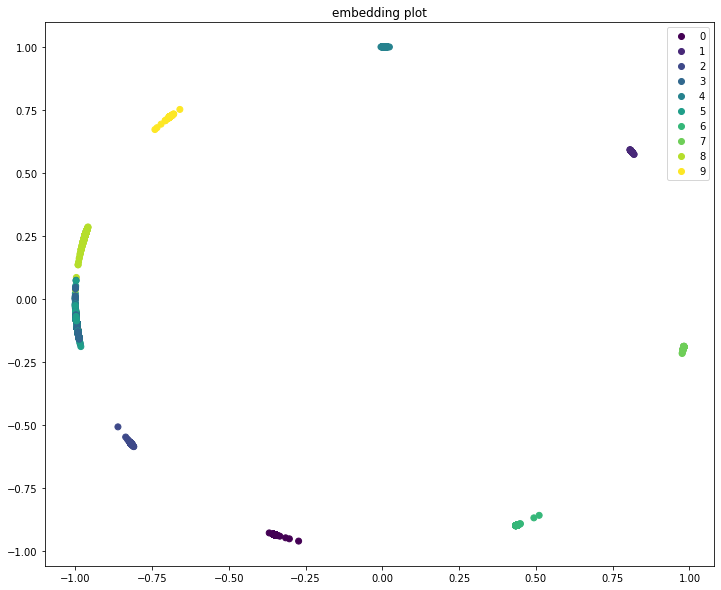

In [ ]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddigs[:, 0], embeddigs[:, 1], c=labels)
plt.legend(handles=scatter.legend_elements()[0], labels=[str(i) for i in range(10)])
plt.title("embedding plot");